# Physical activity monitoring project - ML model traning



In [1]:
# Log in to your W&B account
import wandb

import random
import math
import os
import pandas as pd
import numpy as np

wandb.login()

wandb: Currently logged in as: malithjkd (springleafy) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


True

## MiniRocket + RidgeClassifier exmaple

In [2]:
import os, glob, re, random
import numpy as np
import joblib
import json
from sklearn.linear_model import RidgeClassifierCV
from sklearn.metrics import classification_report, confusion_matrix
#from sktime.transformations.panel.minirocket import MiniRocketMultivariate

from sktime.transformations.panel.rocket import MiniRocket

In [47]:
# Load the unvariate time series dataset
from sktime.datasets import load_unit_test

X_train, y_train = load_unit_test(split="train") 
X_test, y_test = load_unit_test(split="test") 

# Initialize the MiniRocket transformer
trf = MiniRocket(num_kernels=512) 

#  learns the patterns from the training data to `create convolutional kernels.
trf.fit(X_train)

# applies these kernels to both the training and testing data, converting the raw time series into a set of features that a standard classifier can use.
X_train_tf = trf.transform(X_train) 
X_test_tf = trf.transform(X_test)

In [65]:
print(type(X_train))
print(X_train.shape, X_test.shape)
print(X_train_tf.shape, X_test_tf.shape)

<class 'pandas.core.frame.DataFrame'>
(20, 1) (22, 1)
(20, 504) (22, 504)


In [75]:


# convert X_train to numpy array
X_train_np = X_train.to_numpy()
X_test_np = X_test.to_numpy()

print(type(X_train_np))
print(X_train_np.shape, X_test_np.shape)

print(X_train_np[:,0])

<class 'numpy.ndarray'>
(20, 1) (22, 1)
[0      573.0
 1      375.0
 2      301.0
 3      212.0
 4       55.0
 5       34.0
 6       25.0
 7       33.0
 8      113.0
 9      143.0
 10     303.0
 11     615.0
 12    1226.0
 13    1281.0
 14    1221.0
 15    1081.0
 16     866.0
 17    1096.0
 18    1039.0
 19     975.0
 20     746.0
 21     581.0
 22     409.0
 23     182.0
 dtype: float64 0      394.0
                1      264.0
                2      140.0
                3      144.0
                4      104.0
                5       28.0
                6       28.0
                7       25.0
                8       70.0
                9      153.0
                10     401.0
                11     649.0
                12    1216.0
                13    1399.0
                14    1249.0
                15    1240.0
                16    1109.0
                17    1137.0
                18    1290.0
                19    1137.0
                20     791.0
               

In [49]:
# clf = RidgeClassifierCV(alphas=np.logspace(-3, 3, 10))
clf = RidgeClassifierCV(alphas=np.logspace(10, 3, 10))
clf.fit(X_train_tf, y_train)
y_pred = clf.predict(X_test_tf)
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           1       0.85      0.92      0.88        12
           2       0.89      0.80      0.84        10

    accuracy                           0.86        22
   macro avg       0.87      0.86      0.86        22
weighted avg       0.87      0.86      0.86        22



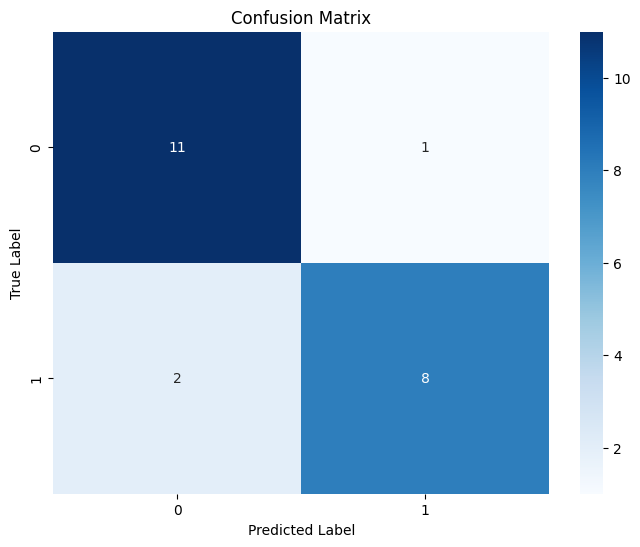

In [50]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Generate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

---

## MiniRocket + RidgeClassifier

In [ ]:

# Define the path to your file
folder_path = r"C:\Users\malit\Documents\GitHub\AI_ML_data\PAMAP2_Dataset\activity_chunks_v1"

file_name_without_ext = "subject101"

activity_ids = [3, 5, 6, 7]
activity_id = 3 # set a default activity id
chunk_count = 5 # set a default chunk count

file_name = f"{file_name_without_ext}_activity_{activity_id}_chunk_{chunk_count}.csv"
file_path = os.path.join(folder_path, file_name)

# Check if the file exists
if not os.path.isfile(file_path):
    raise FileNotFoundError(f"The file {file_path} does not exist.")

# Load the data, specifying the correct delimiter (comma) and no header
csv_data = np.loadtxt(file_path, delimiter=',', dtype=float, comments=None, skiprows=0, usecols=None, unpack=False, ndmin=0, encoding='utf-8', max_rows=None)
np.set_printoptions(precision=6, suppress=True)

print(f"Loaded data from {file_path}")
print(f"Data shape: {csv_data.shape}")  
print(csv_data)

In [ ]:


DATA_DIR = r"C:\\Users\\malit\\Documents\\GitHub\\AI_ML_data\\PAMAP2_Dataset\\activity_chunks_v1"
TARGET_ACTIVITIES = [3,5,6,7]
SAMPLES_PER_CLASS = 50
FEATURE_LIMIT = 40
SEQ_LEN = 100
SEED = 42
out_dir = 'models/minirocket_baseline'
os.makedirs(out_dir, exist_ok=True)

rng = random.Random(SEED)

def parse_activity(fp):
    m = re.search(r"activity_(\d+)_chunk", os.path.basename(fp))
    return int(m.group(1)) if m else None

# 1 Collect & group
paths = [p for p in glob.glob(os.path.join(DATA_DIR,'*.csv')) if parse_activity(p) in TARGET_ACTIVITIES]
by_act = {a: [] for a in TARGET_ACTIVITIES}
for p in paths: by_act[parse_activity(p)].append(p)
for a in TARGET_ACTIVITIES: rng.shuffle(by_act[a])

# 2 Sample balanced
selected = []
for a in TARGET_ACTIVITIES: selected.extend(by_act[a][:SAMPLES_PER_CLASS])

# 3-5 Load & build tensor list
X_list, y_list = [], []
for fp in selected:
    arr = np.loadtxt(fp, delimiter=',', dtype=float)
    feat_idx = [i for i in range(arr.shape[1]) if i not in (0,1)][:FEATURE_LIMIT]
    seq = arr[:, feat_idx].T   # (F, T)
    if seq.shape != (FEATURE_LIMIT, SEQ_LEN):
        continue
    X_list.append(seq)
    y_list.append(parse_activity(fp))

X = np.stack(X_list)  # (N, F, T)
y = np.array(y_list)

# 6 Split
idx = np.arange(len(X)); rng.shuffle(list(idx))
tr_end = int(0.7*len(idx)); va_end = int(0.85*len(idx))
tr, va, te = idx[:tr_end], idx[tr_end:va_end], idx[va_end:]
Xtr, Xva, Xte = X[tr], X[va], X[te]
ytr, yva, yte = y[tr], y[va], y[te]

# 7-8 MiniRocket fit/transform
mr = MiniRocketMultivariate(random_state=SEED)
mr.fit(Xtr)
Phi_tr = mr.transform(Xtr)
Phi_va = mr.transform(Xva)
Phi_te = mr.transform(Xte)

# 9 RidgeClassifierCV
clf = RidgeClassifierCV(alphas=np.logspace(-3,3,7))
clf.fit(Phi_tr, ytr)
print('Val acc:', clf.score(Phi_va, yva))
print('Test acc:', clf.score(Phi_te, yte))
print(classification_report(yte, clf.predict(Phi_te)))
print(confusion_matrix(yte, clf.predict(Phi_te)))

# 10 Save artifacts
joblib.dump(mr, os.path.join(out_dir,'transform.pkl'))
joblib.dump(clf, os.path.join(out_dir,'ridge.pkl'))
with open(os.path.join(out_dir,'config.json'),'w') as f:
    json.dump({'activities': TARGET_ACTIVITIES, 'feature_limit': FEATURE_LIMIT, 'seq_len': SEQ_LEN, 'seed': SEED}, f, indent=2)
